In [2]:
import pandas as pd
from hierarchicalforecast.utils import aggregate
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp
import matplotlib.pyplot as plt

In [3]:
# Configuración inicial
BANCOS = [40002, 40012, 40014, 40021, 40072]
CREDITO_ROOT = 40100185
CONCEPTOS_RANGO = (CREDITO_ROOT, 40100223)

In [4]:
def cargar_datos():
    """Carga y filtra datos"""
    dtypes_conceptos = {
        'idtema': 'int8', 'idconcepto': 'int32', 'nivel': 'int8', 
        'indicador': 'int8', 'orden': 'int16'
    }
    
    df_conceptos = pd.read_csv(
        './data/cat_conceptos_40.csv', 
        encoding='latin1',
        dtype=dtypes_conceptos
    ).query(f'idconcepto >= {CONCEPTOS_RANGO[0]} & idconcepto <= {CONCEPTOS_RANGO[1]}')
    
    dtypes_data = {
        'sector': 'int8', 'idconcepto': 'int32', 'entidad': 'int32',
        'periodo': 'int32', 'saldo': 'float32', 'valor': 'float32'
    }
    
    df_data = pd.read_csv(
        './data/sh_datos_40.csv', 
        encoding='latin1',
        dtype=dtypes_data
    ).query(f'entidad in {BANCOS} & idconcepto >= {CONCEPTOS_RANGO[0]} & idconcepto <= {CONCEPTOS_RANGO[1]}')
    
    return df_conceptos, df_data

# 1. Carga y preparación de datos
df_conceptos, df_data = cargar_datos()

In [5]:
def construir_jerarquia(df_conceptos):
    """Construye la jerarquía con operaciones vectorizadas"""
    df_sorted = df_conceptos.sort_values('orden')
    niveles = df_sorted['nivel'].values
    conceptos = df_sorted['idconcepto'].values
    
    hierarchy = []
    last_parents = {}
    
    for i, (nivel, concepto) in enumerate(zip(niveles, conceptos)):
        if nivel > 3:
            parent_nivel = nivel - 1
            parent = last_parents.get(parent_nivel)
            if parent:
                hierarchy.append((concepto, parent))
        last_parents[nivel] = concepto
        
    return hierarchy, dict(zip(conceptos, niveles))

# 2. Construcción de jerarquía
hierarchy, level_map = construir_jerarquia(df_conceptos)
parent_dict = {child: parent for child, parent in hierarchy}

In [15]:
def get_ancestor_chain_dynamic(leaf, parent_dict, level_map, base_level=3, global_max_level=None):
    """
    Devuelve un diccionario con la cadena de ancestros desde base_level hasta el nivel del nodo hoja.
    """
    chain = {}
    current = leaf
    current_level = level_map.get(current)

    if current_level is None or current_level < base_level:
        return {}
    
    # Rastrear ancestros hasta base_level
    while current is not None and current_level >= base_level:
        chain[f'level{current_level}'] = current
        current = parent_dict.get(current)
        current_level = level_map.get(current, 0) if current else 0

    # Completar hasta global_max_level si está definido
    if global_max_level:
        for lvl in range(base_level, global_max_level + 1):
            key = f'level{lvl}'
            if key not in chain:
                chain[key] = None  # Será reemplazado posteriormente
    
    return dict(sorted(chain.items(), key=lambda x: int(x[0][5:])))

def procesar_datos(df_data, hierarchy, level_map):
    """Procesamiento que incluye hojas en cualquier nivel."""
    parent_dict = {child: parent for child, parent in hierarchy}
    padres = {p for _, p in hierarchy}
    hojas = [c for c in level_map if c not in padres]  # Todas las hojas

    # Calcular nivel máximo global
    global_max_level = max(level_map.values()) if level_map else 0

    # Construir spec con todos los niveles hasta el máximo global
    spec = [
        ['entidad'] + [f'level{l}' for l in range(3, global_max_level + 1)]
    ]
    
    # Procesar datos base
    df_proc = (
        df_data[df_data['idconcepto'].isin(hojas)]
        .assign(
            ds=lambda x: pd.to_datetime(x['periodo'], format='%Y%m'),
            entidad=lambda x: x['entidad'].astype('category')
        )
    )
    
    # Construir cadenas de ancestros
    placeholder = "_N/A_"
    cadenas = []
    for hoja in hojas:
        chain = get_ancestor_chain_dynamic(
            hoja, 
            parent_dict, 
            level_map,
            base_level=3,
            global_max_level=global_max_level
        )
        chain['idconcepto'] = hoja
        cadenas.append(chain)
    
    # Crear DataFrame y rellenar faltantes
    df_chain = pd.json_normalize(cadenas).fillna(placeholder)
    
    # Convertir a categoría (maneja placeholder correctamente)
    for col in df_chain.columns:
        if 'level' in col:
            df_chain[col] = df_chain[col].astype('category')
    
    # Unir y procesar
    df_procesado = df_proc.merge(df_chain, on='idconcepto')
    return aggregate(
        df_procesado.rename(columns={'valor': 'y'}),
        spec=spec
    )

Y_hier_df, S_df, tags = procesar_datos(df_data, hierarchy, level_map)

display(S_df)

,unique_id,40002/40100186.0/40100187.0/40100188.0/_N/A_,40002/40100186.0/40100187.0/40100189.0/_N/A_,40002/40100186.0/40100187.0/40100190.0/_N/A_,40002/40100186.0/40100187.0/40100191.0/_N/A_,40002/40100186.0/40100187.0/40100192.0/_N/A_,40002/40100186.0/40100187.0/40100193.0/_N/A_,40002/40100186.0/40100187.0/40100194.0/_N/A_,40002/40100186.0/40100187.0/40100195.0/_N/A_,40002/40100186.0/40100196.0/40100197.0/_N/A_,...,40072/40100206.0/40100208.0/40100214.0/_N/A_,40072/40100206.0/40100208.0/40100215.0/_N/A_,40072/40100206.0/40100208.0/40100216.0/_N/A_,40072/40100217.0/40100218.0/_N/A_/_N/A_,40072/40100217.0/40100219.0/_N/A_/_N/A_,40072/40100217.0/40100220.0/_N/A_/_N/A_,40072/40100217.0/40100221.0/_N/A_/_N/A_,40072/40100217.0/40100222.0/_N/A_/_N/A_,40072/40100217.0/40100223.0/_N/A_/_N/A_,40072/_N/A_/_N/A_/_N/A_/_N/A_
0,40002/40100186.0/40100187.0/40100188.0/_N/A_,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40002/40100186.0/40100187.0/40100189.0/_N/A_,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40002/40100186.0/40100187.0/40100190.0/_N/A_,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40002/40100186.0/40100187.0/40100191.0/_N/A_,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40002/40100186.0/40100187.0/40100192.0/_N/A_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,40072/40100217.0/40100220.0/_N/A_/_N/A_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
151,40072/40100217.0/40100221.0/_N/A_/_N/A_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
152,40072/40100217.0/40100222.0/_N/A_/_N/A_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
153,40072/40100217.0/40100223.0/_N/A_/_N/A_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
def pronosticar_y_reconciliar(Y_hier_df):
    """Ejecuta el pipeline de pronóstico optimizado"""
    # Preparar datos
    df_train = Y_hier_df[['unique_id', 'ds', 'y']].astype({
        'unique_id': 'category', 
        'ds': 'datetime64[ns]',
        'y': 'float32'
    })
    
    # Modelado paralelizado
    sf = StatsForecast(
        models=[AutoARIMA(season_length=12)],
        freq='ME',
        n_jobs=-1
    )
    sf.fit(df_train)
    
    # Pronóstico y reconciliación
    forecast = sf.predict(h=30)
    reconciler = HierarchicalReconciliation(reconcilers=[BottomUp()])
    reconciled = reconciler.reconcile(
        Y_hat_df=forecast,
        Y_df=df_train,
        S=S_df,
        tags=tags
    )
    
    return forecast, reconciled

# 4. Pronóstico y reconciliación
forecast, reconciled = pronosticar_y_reconciliar(Y_hier_df)

In [17]:
def calcular_participacion(reconciled):
    """Cálculo vectorizado de participación de mercado"""
    # Convertir a estructura wide para cálculo eficiente
    df_wide = (
        reconciled.set_index(['ds', 'unique_id'])['AutoARIMA/BottomUp']
        .unstack()
        .astype('float32')
    )
    
    total_sistema = df_wide.sum(axis=1)
    participacion = df_wide.div(total_sistema, axis=0)
    
    return participacion

# 5. Cálculo de participación
participacion = calcular_participacion(reconciled)

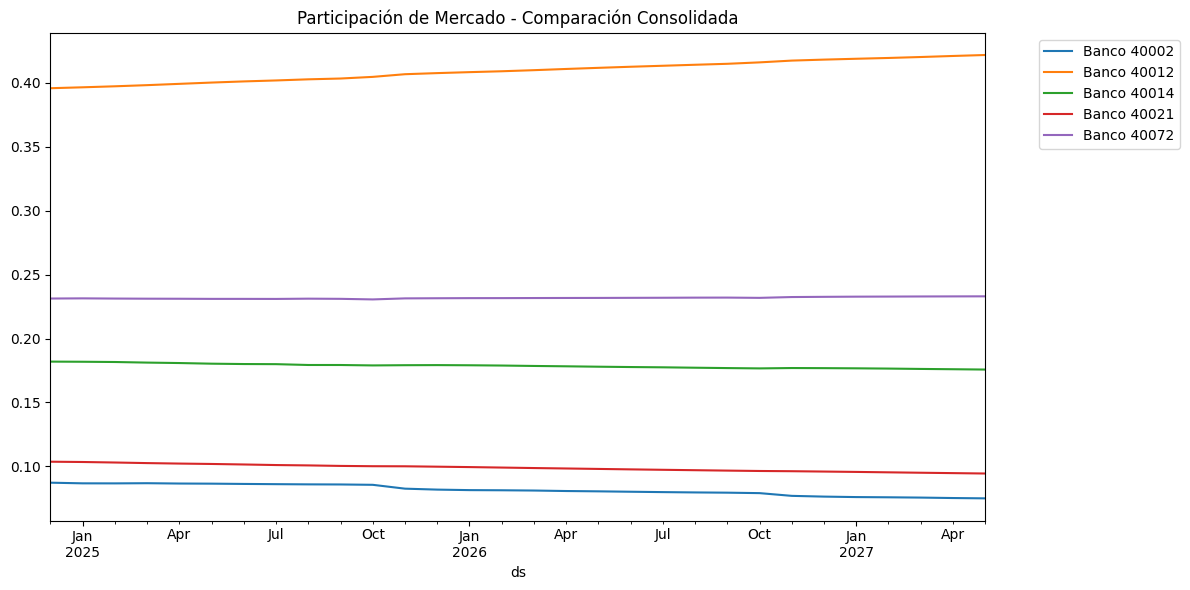

In [9]:
def visualizar_resultados(participacion):
    """Visualización optimizada"""
    plt.figure(figsize=(12, 6))
    for banco in BANCOS:
        mask = participacion.columns.str.startswith(f"{banco}/")
        datos = participacion.loc[:, mask].sum(axis=1)
        datos.plot(label=f'Banco {banco}')
    
    plt.title('Participación de Mercado - Comparación Consolidada')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 6. Visualización
visualizar_resultados(participacion)

In [26]:
# Función para procesar los datos de pronóstico
def procesar_pronosticos(reconciled, forecast):
    # Separar unique_id en entidad y concepto
    reconciled['entidad'] = reconciled['unique_id'].str.split('/', expand=True)[0]
    reconciled['idconcepto'] = reconciled['unique_id'].str.split('/').str[-1]
    forecast['entidad'] = forecast['unique_id'].str.split('/', expand=True)[0]
    forecast['idconcepto'] = forecast['unique_id'].str.split('/').str[-1]
    
    # Convertir fechas a formato adecuado
    reconciled['periodo'] = reconciled['ds'].dt.to_period('M').dt.end_time
    forecast['periodo'] = forecast['ds'].dt.to_period('M').dt.end_time
    
    # Crear tabla de comparación
    comparison_df = pd.merge(
        reconciled[['entidad', 'idconcepto', 'periodo', 'AutoARIMA/BottomUp']],
        forecast[['entidad', 'idconcepto', 'periodo', 'AutoARIMA']],
        on=['entidad', 'idconcepto', 'periodo']
    )
    
    # Calcular diferencia porcentual
    comparison_df['Diferencia (%)'] = (
        (comparison_df['AutoARIMA/BottomUp'] - comparison_df['AutoARIMA']) / 
        comparison_df['AutoARIMA']
    ) * 100
    
    return comparison_df, reconciled, forecast
 
# Procesar datos
comparison_df, reconciled_df, forecast_df = procesar_pronosticos(reconciled, forecast)
 
# Exportar tablas clave
comparison_df.to_csv('comparison_data.csv', index=False)
reconciled_df.to_csv('reconciled_forecast.csv', index=False)
forecast_df.to_csv('traditional_forecast.csv', index=False)
 
# Exportar estructura jerárquica
S_df.reset_index().to_csv('hierarchy_structure.csv', index=False)
# pd.DataFrame(tags).to_csv('hierarchy_tags.csv', index=False)
 
# Exportar participación de mercado
def calcular_participacion(df):
    total_por_periodo = df.groupby('periodo')['AutoARIMA/BottomUp'].transform('sum')
    df['Participacion'] = (df['AutoARIMA/BottomUp'] / total_por_periodo) * 100
    return df
 
market_share_df = reconciled_df.groupby(['entidad', 'periodo']).sum(numeric_only=True).reset_index()
# market_share_df = calcular_participacion(market_share_df.pivot_table(
#     index='periodo', columns='entidad', values='Participacion'
# )).reset_index()

# market_share_df.to_csv('market_share.csv', index=False)

display(market_share_df)

,entidad,periodo,AutoARIMA,AutoARIMA/BottomUp
0,40002,2024-12-31 23:59:59.999999999,6.771261e+12,6.896594e+12
1,40002,2025-01-31 23:59:59.999999999,6.751850e+12,6.894502e+12
2,40002,2025-02-28 23:59:59.999999999,6.786940e+12,6.933291e+12
3,40002,2025-03-31 23:59:59.999999999,6.822279e+12,6.986264e+12
4,40002,2025-04-30 23:59:59.999999999,6.835262e+12,7.007728e+12
...,...,...,...,...
145,40072,2027-01-31 23:59:59.999999999,2.118487e+13,2.100207e+13
146,40072,2027-02-28 23:59:59.999999999,2.130489e+13,2.111359e+13
147,40072,2027-03-31 23:59:59.999999999,2.142294e+13,2.122448e+13
148,40072,2027-04-30 23:59:59.999999999,2.154007e+13,2.133694e+13


In [63]:
import numpy as np

# Convertir a numérico, eliminando NaN y valores infinitos
valid_values = comparison_df['Diferencia (%)'].dropna()
valid_values = valid_values[~valid_values.isin([np.inf, -np.inf])]

# Filtrar valores entre -100 y 100
valid_values = valid_values[(valid_values >= -100) & (valid_values <= 100)]

# Calcular la media
mean_value = valid_values.mean() if not valid_values.empty else np.nan

print(mean_value)

-75.1325373648269


In [69]:
display(forecast)

,unique_id,ds,AutoARIMA,entidad,idconcepto,periodo
0,40002/0.0,2024-12-31,8.188719e+11,40002,0.0,2024-12-31 23:59:59.999999999
1,40002/0.0,2025-01-31,8.087807e+11,40002,0.0,2025-01-31 23:59:59.999999999
2,40002/0.0,2025-02-28,8.137867e+11,40002,0.0,2025-02-28 23:59:59.999999999
3,40002/0.0,2025-03-31,8.168106e+11,40002,0.0,2025-03-31 23:59:59.999999999
4,40002/0.0,2025-04-30,8.147915e+11,40002,0.0,2025-04-30 23:59:59.999999999
...,...,...,...,...,...,...
11545,40072/40100217.0/40100223.0/0.0/0.0,2027-01-31,0.000000e+00,40072,0.0,2027-01-31 23:59:59.999999999
11546,40072/40100217.0/40100223.0/0.0/0.0,2027-02-28,0.000000e+00,40072,0.0,2027-02-28 23:59:59.999999999
11547,40072/40100217.0/40100223.0/0.0/0.0,2027-03-31,0.000000e+00,40072,0.0,2027-03-31 23:59:59.999999999
11548,40072/40100217.0/40100223.0/0.0/0.0,2027-04-30,0.000000e+00,40072,0.0,2027-04-30 23:59:59.999999999


In [68]:
# Extraer el código del banco a partir de unique_id.
# Se asume que unique_id tiene el formato "banco_idconcepto", separado por '_'
forecast['entidad'] = forecast['unique_id'].str.split('/').str[0]
reconciled['entidad'] = reconciled['unique_id'].str.split('/').str[0]

# Agrupar por banco y fecha (ds) y sumar los volúmenes de cartera:
trad_summary = forecast.groupby(['entidad', 'ds'])['AutoARIMA'].sum().reset_index()
hier_summary = reconciled.groupby(['entidad', 'ds'])['AutoARIMA/BottomUp'].sum().reset_index()

# Unir las dos tablas de resumen por banco y fecha
summary = pd.merge(trad_summary, hier_summary, on=['entidad', 'ds'], how='outer')

# Renombrar las columnas para mayor claridad
summary = summary.rename(columns={
    'AutoARIMA': 'Pronóstico Tradicional',
    'AutoARIMA/BottomUp': 'Pronóstico Jerárquico'
})

# Opcional: Ordenar por banco y fecha
summary = summary.sort_values(['entidad', 'ds']).reset_index(drop=True)
summary.to_csv('summary.csv', index=False)
# Mostrar la tabla resultante
display(summary)

,entidad,ds,Pronóstico Tradicional,Pronóstico Jerárquico
0,40002,2024-12-31,6.771261e+12,6.896594e+12
1,40002,2025-01-31,6.751850e+12,6.894502e+12
2,40002,2025-02-28,6.786940e+12,6.933291e+12
3,40002,2025-03-31,6.822279e+12,6.986264e+12
4,40002,2025-04-30,6.835262e+12,7.007728e+12
...,...,...,...,...
145,40072,2027-01-31,2.118487e+13,2.100207e+13
146,40072,2027-02-28,2.130489e+13,2.111359e+13
147,40072,2027-03-31,2.142294e+13,2.122448e+13
148,40072,2027-04-30,2.154007e+13,2.133694e+13


In [78]:
import pandas as pd

# Participación de mercado para el pronóstico tradicional
trad_summary = forecast.groupby(['entidad', 'ds'])['AutoARIMA'].sum().reset_index()
trad_total = trad_summary.groupby('ds')['AutoARIMA'].transform('sum')
trad_summary['Participacion (%)'] = (trad_summary['AutoARIMA'] / trad_total)
participacion_trad = trad_summary.pivot(index='ds', columns='entidad', values='Participacion (%)').reset_index()
participacion_trad.to_csv('participacion_trad.csv', index=False)

print("Participación de Mercado - Pronóstico Tradicional")
display(participacion_trad)

# Participación de mercado para el pronóstico jerárquico
hier_summary = reconciled.groupby(['entidad', 'ds'])['AutoARIMA/BottomUp'].sum().reset_index()
hier_total = hier_summary.groupby('ds')['AutoARIMA/BottomUp'].transform('sum')
hier_summary['Participacion (%)'] = (hier_summary['AutoARIMA/BottomUp'] / hier_total)
participacion_hier = hier_summary.pivot(index='ds', columns='entidad', values='Participacion (%)').reset_index()
participacion_hier.to_csv('participacion_hier.csv', index=False)

print("Participación de Mercado - Pronóstico Jerárquico")
display(participacion_hier)


Participación de Mercado - Pronóstico Tradicional


entidad,ds,40002,40012,40014,40021,40072
0,2024-12-31,0.085749,0.396793,0.181775,0.103806,0.231877
1,2025-01-31,0.085022,0.397672,0.181606,0.103551,0.232149
2,2025-02-28,0.084941,0.398513,0.181349,0.103199,0.231997
3,2025-03-31,0.084855,0.399438,0.180942,0.102797,0.231969
4,2025-04-30,0.084493,0.400470,0.180597,0.102456,0.231984
5,2025-05-31,0.084315,0.401455,0.180189,0.102180,0.231861
6,2025-06-30,0.084004,0.402367,0.179887,0.101822,0.231920
7,2025-07-31,0.083729,0.403230,0.179678,0.101421,0.231941
8,2025-08-31,0.083505,0.404091,0.179184,0.101128,0.232091
9,2025-09-30,0.083360,0.404864,0.179007,0.100756,0.232013


Participación de Mercado - Pronóstico Jerárquico


entidad,ds,40002,40012,40014,40021,40072
0,2024-12-31,0.087200,0.395911,0.181950,0.103620,0.231318
1,2025-01-31,0.086693,0.396626,0.181840,0.103389,0.231452
2,2025-02-28,0.086657,0.397414,0.181644,0.102991,0.231295
3,2025-03-31,0.086792,0.398310,0.181179,0.102530,0.231189
4,2025-04-30,0.086538,0.399325,0.180833,0.102160,0.231144
5,2025-05-31,0.086440,0.400333,0.180330,0.101850,0.231047
6,2025-06-30,0.086224,0.401232,0.180051,0.101449,0.231045
7,2025-07-31,0.086042,0.401989,0.179959,0.101002,0.231008
8,2025-08-31,0.085888,0.402868,0.179308,0.100723,0.231212
9,2025-09-30,0.085807,0.403495,0.179296,0.100323,0.231079
